# Special Notes on Evaluation

The interpretability methods should give explanations on two levels, on the global and local level.

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from comparers import plot_decision_boundary, ModelComparer
import shap
from tasks.adult import make_task_without_noise, make_task_with_noise
from util import calc_ground_truth_constraints, constraint_matrix_to_rules
from surrogate_tree import plot_feature_importances, get_feature_importances
shap.initjs()

In [3]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

# Tasks

## Model Trained on Original Data

In [4]:
clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = make_task_without_noise()

[08:28:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:28:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:28:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above c

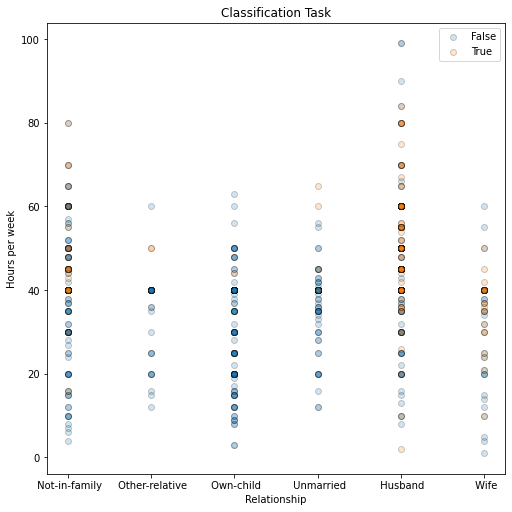

In [4]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X, y, 'Classification Task', feature_names,
                       X_display=X_display, idx_x=5, idx_y=10, fig=fig, ax=ax, alpha=0.2)

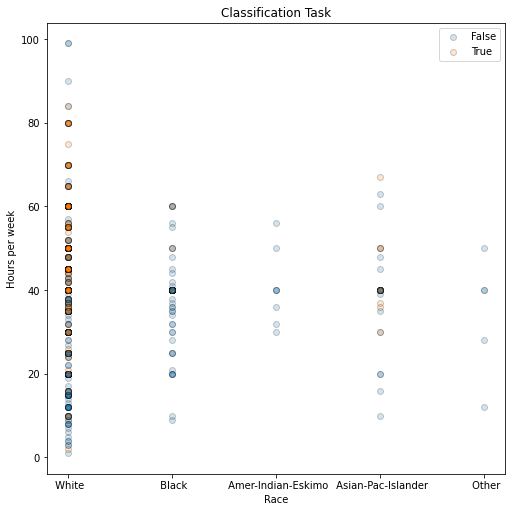

In [5]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X, y, 'Classification Task', feature_names,
                       X_display=X_display, idx_x=6, idx_y=10, fig=fig, ax=ax, alpha=0.2)

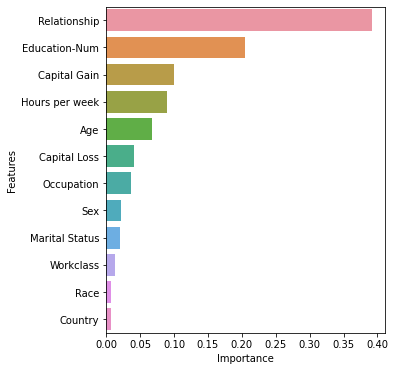

In [6]:
feature_importances, feature_order = get_feature_importances(clf_a)
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 6))

In [7]:
y_pred = clf_a.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

       False       0.88      0.95      0.92       742
        True       0.79      0.61      0.69       235

    accuracy                           0.87       977
   macro avg       0.84      0.78      0.80       977
weighted avg       0.86      0.87      0.86       977



In [9]:
from pprint import pprint
mappings = {}
for feature_name in categorical_features:
    feature_idx = list(feature_names).index(feature_name)
    mapping = {}
    for value in np.unique(X[:, feature_idx]).astype(int):
        idx = np.where(X[:, feature_idx] == value)[0][0]
        display_value = X_display[:, feature_idx][idx]
        mapping[value] = display_value
    mappings[feature_name] = mapping
pprint(mappings)

{'Country': {0: ' ?',
             2: ' Canada',
             3: ' China',
             5: ' Cuba',
             6: ' Dominican-Republic',
             7: ' Ecuador',
             8: ' El-Salvador',
             9: ' England',
             10: ' France',
             11: ' Germany',
             12: ' Greece',
             13: ' Guatemala',
             14: ' Haiti',
             18: ' Hungary',
             19: ' India',
             20: ' Iran',
             22: ' Italy',
             23: ' Jamaica',
             24: ' Japan',
             25: ' Laos',
             26: ' Mexico',
             27: ' Nicaragua',
             28: ' Outlying-US(Guam-USVI-etc)',
             29: ' Peru',
             30: ' Philippines',
             31: ' Poland',
             32: ' Portugal',
             33: ' Puerto-Rico',
             35: ' South',
             36: ' Taiwan',
             39: ' United-States',
             40: ' Vietnam',
             41: ' Yugoslavia'},
 'Education-Num': {1: 1.0,
   

## Modified Influential Feature

In [4]:
clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = make_task_without_noise()
with open('task_without_noise.pickle', 'wb') as f:
    pickle.dump((clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions),
                f, pickle.HIGHEST_PROTOCOL)

[10:46:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:46:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:46:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above c

In [5]:
with open('task_without_noise.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = pickle.load(f)

In [6]:
y_pred_a = clf_a.predict(X)
print(classification_report(y, y_pred_a))

              precision    recall  f1-score   support

       False       0.88      0.95      0.92       742
        True       0.79      0.61      0.69       235

    accuracy                           0.87       977
   macro avg       0.84      0.78      0.80       977
weighted avg       0.86      0.87      0.86       977



In [7]:
y_pred_b = clf_b.predict(X)
print(classification_report(y, y_pred_b))

              precision    recall  f1-score   support

       False       0.89      0.94      0.92       742
        True       0.78      0.64      0.71       235

    accuracy                           0.87       977
   macro avg       0.84      0.79      0.81       977
weighted avg       0.87      0.87      0.87       977



In [8]:
clf_a.importance_type

'gain'

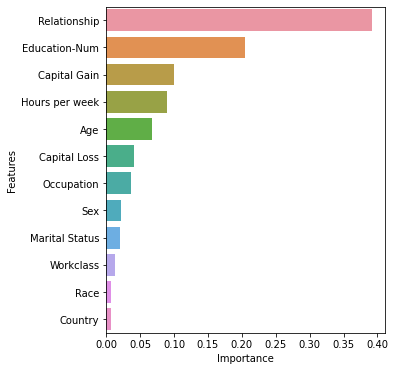

In [9]:
feature_importances, feature_order = get_feature_importances(clf_a)
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 6))

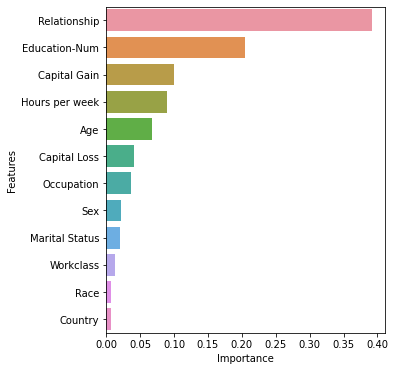

In [10]:
feature_importances, feature_order = get_feature_importances(clf_b)
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 6))

In [11]:
accuracy_score(y, y_pred_b) - accuracy_score(y, y_pred_a)

0.004094165813715467

In [12]:
f1_score(y, y_pred_b) - f1_score(y, y_pred_a)

0.018107476635514153

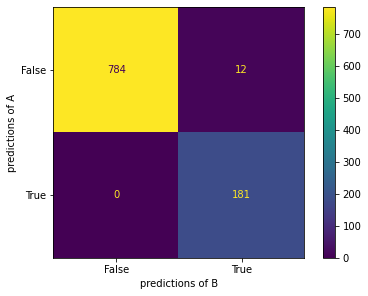

In [13]:
comparer = ModelComparer(clf_a, clf_b, feature_names)
comparer.plot_confusion_matrix(X)

In [14]:
clf_b.feature_importances_ - clf_a.feature_importances_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [15]:
mask = y_pred_a != y_pred_b
df = pd.DataFrame(X[mask], columns=feature_names, index=np.where(mask)[0])
instances_without_noise_indices = df.index.to_numpy()
df

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
64,52.0,4.0,10.0,2.0,3.0,4.0,4.0,1.0,0.0,0.0,40.0,39.0
70,37.0,4.0,13.0,2.0,7.0,4.0,4.0,1.0,0.0,0.0,40.0,39.0
406,50.0,4.0,10.0,2.0,3.0,4.0,4.0,1.0,0.0,0.0,40.0,39.0
484,49.0,5.0,9.0,2.0,4.0,4.0,4.0,1.0,0.0,0.0,40.0,39.0
531,61.0,5.0,15.0,5.0,10.0,0.0,4.0,1.0,0.0,0.0,40.0,39.0
558,39.0,4.0,14.0,4.0,10.0,0.0,4.0,1.0,6849.0,0.0,40.0,39.0
701,60.0,4.0,12.0,2.0,1.0,4.0,4.0,1.0,0.0,0.0,40.0,39.0
744,50.0,4.0,9.0,2.0,4.0,4.0,4.0,1.0,0.0,0.0,40.0,39.0
883,28.0,4.0,14.0,2.0,10.0,4.0,4.0,1.0,0.0,0.0,40.0,39.0
925,30.0,4.0,13.0,2.0,8.0,5.0,4.0,0.0,0.0,0.0,40.0,39.0


In [16]:
y_pred_diff_a = clf_a.predict_proba(df)[:, 1]
y_pred_diff_a

array([0.44480926, 0.48006028, 0.44480926, 0.46489137, 0.43284997,
       0.40269968, 0.4665346 , 0.46489137, 0.44528347, 0.427984  ,
       0.42766833, 0.43893462], dtype=float32)

In [17]:
y_pred_diff_b = clf_b.predict_proba(df)[:, 1]
y_pred_diff_b

array([0.524318  , 0.58032864, 0.524318  , 0.5444694 , 0.545458  ,
       0.51458085, 0.59269375, 0.5444694 , 0.5104793 , 0.52843   ,
       0.50691056, 0.51837367], dtype=float32)

In [18]:
[(y.min(), y.max()) for y in [y_pred_diff_a, y_pred_diff_b]]

[(0.40269968, 0.48006028), (0.50691056, 0.59269375)]

Both classifiers predict a probability close to the decision boundary.

### Ground Truth

In [21]:
%%time
for label in comparer.difference_class_names:
    print(label)
    ground_truth_instance_indices, ground_truth = calc_ground_truth_constraints(comparer, feature_precisions, X, label)
    with open(f'ground_truth.{label}.pickle', 'wb') as f:
        pickle.dump((ground_truth_instance_indices, ground_truth), f)
    rules = constraint_matrix_to_rules(ground_truth, feature_names)
    for instance_idx, rule in zip(ground_truth_instance_indices, rules):
        print(f'{instance_idx}: {rule}')
    print()

(False, True)
64: 43.0 < Age <= 61.0 and 1.0 < Workclass <= 5.0 and 9.0 < `Education-Num` <= 12.0 and `Marital Status` <= 2.0 and 0.0 < Occupation <= 3.0 and 3.0 < Relationship <= 4.0 and Race > 3.0 and Sex > 0.0 and `Capital Gain` <= 56.0 and `Capital Loss` <= 731.0 and 39.0 < `Hours per week` <= 41.0 and Country > 35.0
70: 33.0 < Age <= 43.0 and 1.0 < Workclass <= 5.0 and 12.0 < `Education-Num` <= 14.0 and `Marital Status` <= 3.0 and 4.0 < Occupation <= 9.0 and 3.0 < Relationship <= 4.0 and Race > 0.0 and `Capital Gain` <= 56.0 and `Capital Loss` <= 731.0 and 39.0 < `Hours per week` <= 41.0 and Country > 2.0
406: 43.0 < Age <= 61.0 and 1.0 < Workclass <= 5.0 and 9.0 < `Education-Num` <= 12.0 and `Marital Status` <= 2.0 and 0.0 < Occupation <= 3.0 and 3.0 < Relationship <= 4.0 and Race > 3.0 and Sex > 0.0 and `Capital Gain` <= 56.0 and `Capital Loss` <= 731.0 and 39.0 < `Hours per week` <= 41.0 and Country > 35.0
484: 43.0 < Age <= 61.0 and 1.0 < Workclass <= 5.0 and 8.0 < `Education-

### Additional plots

In [19]:
import explainers

In [20]:
with open('indiv.shap', 'rb') as f:
    shap_values = pickle.load(f)

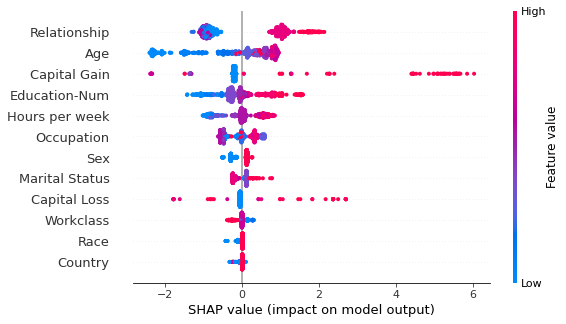

In [21]:
feature_order, feature_importance = explainers.calc_feature_order(shap_values[:, :, 'A.True'])
explainers.plot_feature_importance_scatter(shap_values[:, :, 'A.True'],
                                           feature_order=feature_order,
                                           max_display=len(feature_names),
                                           plot_size=(8,5))

In [22]:
from importlib import reload
import explainers
reload(explainers)
from explainers import *

In [23]:
focus_class = 'A.True'
feature_idx, feature = comparer.check_feature('Age')
compare_feature = 'Education-Num'

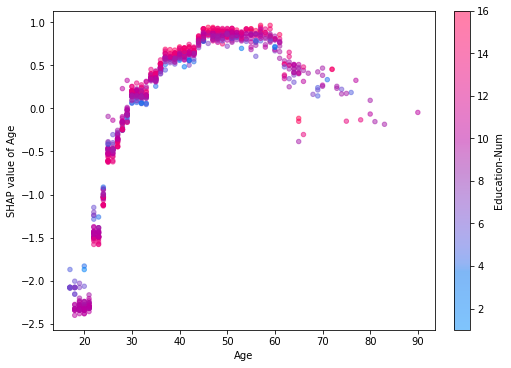

In [24]:
explainers.plot_feature_dependence(shap_values[:, :, focus_class], feature, alpha=0.5,
                                   color=shap_values[:, compare_feature, focus_class].data, color_label=compare_feature)

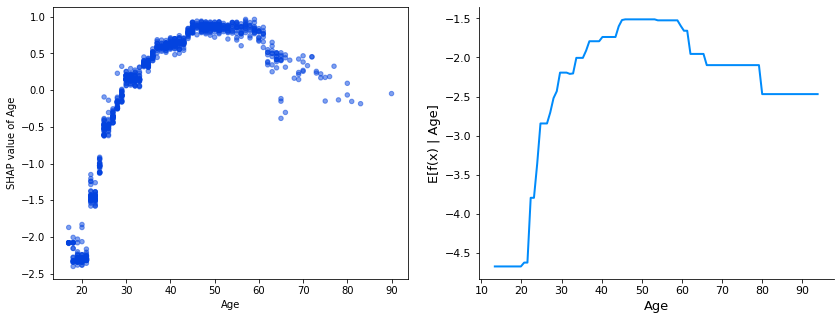

In [25]:
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
plot_feature_dependence(shap_values[:, :, focus_class], feature_idx, alpha=0.5, show=False, ax=axs[0])
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.predict_combined_log_odds(X)[:, 1],
                              data=X,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])

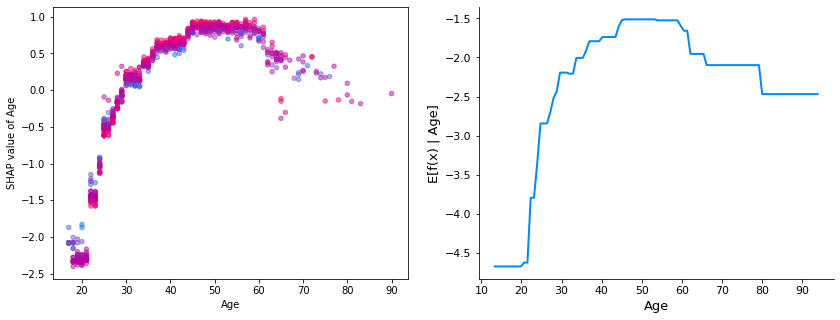

In [35]:
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
plot_feature_dependence(shap_values[:, :, focus_class], feature_idx, alpha=0.5, show=False, ax=axs[0],
                        color=shap_values[:, compare_feature, focus_class].data, color_label=compare_feature)
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.predict_combined_log_odds(X)[:, 1],
                              data=X,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])

## Add Noise

Hypthesis: A good explanation does not depend on small fluctuations in a feature that has no or small influence.
Evaluate: To what extent are the explanations different compared to the previous task?

In [28]:
clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = make_task_with_noise()
with open('task_with_noise.pickle', 'wb') as f:
    pickle.dump((clf_a, clf_b, X, X_display, y, feature_names, categorical_features),
                f, pickle.HIGHEST_PROTOCOL)

[14:35:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:35:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:35:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above c

In [27]:
with open('task_with_noise.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = pickle.load(f)

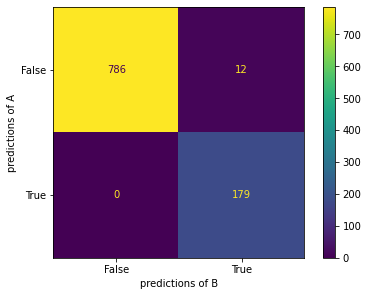

In [28]:
comparer = ModelComparer(clf_a, clf_b, feature_names)
comparer.plot_confusion_matrix(X)

In [29]:
y_pred_a = clf_a.predict(X)
print(classification_report(y, y_pred_a))

              precision    recall  f1-score   support

       False       0.88      0.95      0.92       742
        True       0.80      0.61      0.69       235

    accuracy                           0.87       977
   macro avg       0.84      0.78      0.80       977
weighted avg       0.86      0.87      0.86       977



In [30]:
y_pred_b = clf_b.predict(X)
print(classification_report(y, y_pred_b))

              precision    recall  f1-score   support

       False       0.89      0.95      0.92       742
        True       0.79      0.64      0.71       235

    accuracy                           0.87       977
   macro avg       0.84      0.79      0.81       977
weighted avg       0.87      0.87      0.87       977



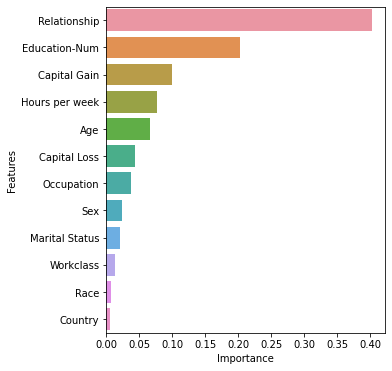

In [31]:
feature_importances, feature_order = get_feature_importances(clf_a)
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 6))

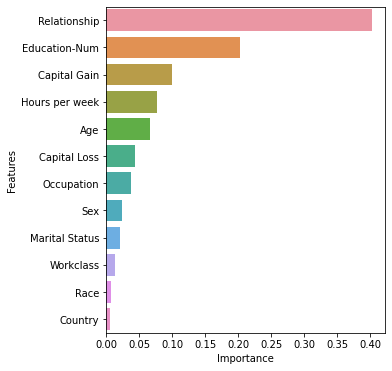

In [32]:
feature_importances, feature_order = get_feature_importances(clf_b)
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 6))

In [33]:
accuracy_score(y, y_pred_b) - accuracy_score(y, y_pred_a)

0.004094165813715467

In [34]:
f1_score(y, y_pred_b) - f1_score(y, y_pred_a)

0.018098931754779835

In [35]:
clf_b.feature_importances_ - clf_a.feature_importances_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [37]:
(clf_b.feature_importances_ - clf_a.feature_importances_)[list(feature_names).index('Capital Loss')]

0.0

In [38]:
mask = y_pred_a != y_pred_b
df = pd.DataFrame(X[mask], columns=feature_names, index=np.where(mask)[0])
instances_with_noise_indices = df.index.to_numpy()
df

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
64,52.0,4.0,10.0,2.0,3.0,4.0,4.0,1.0,0.0,0.0,40.0,39.0
70,37.0,4.0,13.0,2.0,7.0,4.0,4.0,1.0,0.0,1.0,40.0,39.0
406,50.0,4.0,10.0,2.0,3.0,4.0,4.0,1.0,0.0,0.0,40.0,39.0
484,49.0,5.0,9.0,2.0,4.0,4.0,4.0,1.0,0.0,1.0,40.0,39.0
531,61.0,5.0,15.0,5.0,10.0,0.0,4.0,1.0,0.0,1.0,40.0,39.0
558,39.0,4.0,14.0,4.0,10.0,0.0,4.0,1.0,6849.0,0.0,40.0,39.0
701,60.0,4.0,12.0,2.0,1.0,4.0,4.0,1.0,0.0,1.0,40.0,39.0
744,50.0,4.0,9.0,2.0,4.0,4.0,4.0,1.0,0.0,0.0,40.0,39.0
883,28.0,4.0,14.0,2.0,10.0,4.0,4.0,1.0,0.0,0.0,40.0,39.0
925,30.0,4.0,13.0,2.0,8.0,5.0,4.0,0.0,0.0,1.0,40.0,39.0


Both classifiers predict a probability close to the decision boundary.

In [39]:
np.setdiff1d(instances_without_noise_indices, instances_with_noise_indices)

array([], dtype=int64)

In [40]:
np.setdiff1d(instances_with_noise_indices, instances_without_noise_indices)

array([], dtype=int64)

The instances classified differently are the same as before.

### Ground Truth

In [41]:
%%time
for label in comparer.difference_class_names:
    print(label)
    ground_truth_instance_indices, ground_truth = calc_ground_truth_constraints(comparer, feature_precisions, X, label)
    with open(f'ground_truth.test.{label}.pickle', 'wb') as f:
        pickle.dump((ground_truth_instance_indices, ground_truth), f)
    rules = constraint_matrix_to_rules(ground_truth, feature_names)
    for instance_idx, rule in zip(ground_truth_instance_indices, rules):
        print(f'{instance_idx}: {rule}')
    print()

(False, True)
64: 44.0 < Age <= 61.0 and 1.0 < Workclass <= 5.0 and 9.0 < `Education-Num` <= 12.0 and `Marital Status` <= 2.0 and 0.0 < Occupation <= 3.0 and 3.0 < Relationship <= 4.0 and Race > 3.0 and Sex > 0.0 and `Capital Gain` <= 56.0 and `Capital Loss` <= 731.0 and 39.0 < `Hours per week` <= 41.0 and Country > 38.0
70: 33.0 < Age <= 39.0 and 1.0 < Workclass <= 4.0 and 12.0 < `Education-Num` <= 13.0 and `Marital Status` <= 5.0 and 4.0 < Occupation <= 9.0 and 3.0 < Relationship <= 4.0 and Race > 0.0 and Sex > 0.0 and `Capital Gain` <= 56.0 and `Capital Loss` <= 1447.0 and 39.0 < `Hours per week` <= 41.0
406: 44.0 < Age <= 61.0 and 1.0 < Workclass <= 5.0 and 9.0 < `Education-Num` <= 12.0 and `Marital Status` <= 2.0 and 0.0 < Occupation <= 3.0 and 3.0 < Relationship <= 4.0 and Race > 3.0 and Sex > 0.0 and `Capital Gain` <= 56.0 and `Capital Loss` <= 731.0 and 39.0 < `Hours per week` <= 41.0 and Country > 38.0
484: 43.0 < Age <= 61.0 and 1.0 < Workclass <= 5.0 and 8.0 < `Education-Num

# Results

In [182]:
with open('results.baseline.pickle', 'rb') as f:
    global_fidelity_baseline, local_fidelity_baseline, complexity_baseline = pickle.load(f)
with open('results.soa.pickle', 'rb') as f:
    global_fidelity_soa, local_fidelity_soa, complexity_soa = pickle.load(f)
with open('results.proposed.pickle', 'rb') as f:
    global_fidelity_proposed, local_fidelity_proposed, complexity_proposed = pickle.load(f)

In [183]:
global_fidelity = pd.concat([global_fidelity_baseline, global_fidelity_soa, global_fidelity_proposed],
                            keys=['BA', 'SOA', 'PA'], names=['approach'])
global_fidelity = global_fidelity.reorder_levels(['level', 'class', 'approach']).sort_index()
global_fidelity.index = global_fidelity.index.droplevel('class')
global_fidelity

Precision  Recall  F1 Score  Support
level  approach                                      
global PA         0.043165     1.0  0.082759       12
       SOA        0.023166     1.0  0.045283       12
local  BA         1.000000     1.0  1.000000       12
       PA         0.153846     1.0  0.266667       12
       SOA        0.123711     1.0  0.220183       12

In [184]:
print(global_fidelity.to_latex(float_format=lambda x: '{:.2f}'.format(x)))

\begin{tabular}{llrrrr}
\toprule
      &     &  Precision &  Recall &  F1 Score &  Support \\
level & approach &            &         &           &          \\
\midrule
global & PA &       0.04 &    1.00 &      0.08 &       12 \\
      & SOA &       0.02 &    1.00 &      0.05 &       12 \\
local & BA &       1.00 &    1.00 &      1.00 &       12 \\
      & PA &       0.15 &    1.00 &      0.27 &       12 \\
      & SOA &       0.12 &    1.00 &      0.22 &       12 \\
\bottomrule
\end{tabular}



In [185]:
local_fidelity = pd.concat([local_fidelity_baseline, local_fidelity_soa, local_fidelity_proposed],
                             axis=1, keys=['BA', 'SOA', 'PA'], names=['approach', 'metric'])
local_fidelity = local_fidelity.reorder_levels(['metric', 'approach'], axis=1).sort_index(axis=1)
local_fidelity.index = local_fidelity.index.droplevel('class')
local_fidelity

metric                 BAR                      BMR                      \
approach                BA   PA       SOA        BA        PA       SOA   
level  feature                                                            
global Age             NaN  0.0       NaN       NaN  0.000000  1.000000   
       Capital Gain    NaN  0.0       NaN       NaN  0.076923  1.000000   
       Capital Loss    NaN  NaN       NaN       NaN  1.000000  1.000000   
       Country         NaN  NaN       NaN       NaN  1.000000  1.000000   
       Education-Num   NaN  0.0       NaN       NaN  0.478261  1.000000   
       Hours per week  NaN  0.0  0.000000       NaN  0.000000  0.541667   
       Marital Status  NaN  NaN  0.000000       NaN  1.000000  0.916667   
       Occupation      NaN  NaN       NaN       NaN  1.000000  1.000000   
       Race            NaN  NaN  0.000000       NaN  1.000000  0.000000   
       Relationship    NaN  NaN  0.166667       NaN  1.000000  0.473684   
       Sex             NaN  NaN  0.250000       NaN  1.000000  0.000000   
       Workclass       NaN  NaN       NaN       NaN  1.000000  1.000000   
local  Age             0.0  0.0  0.000000  0.291667  0.000000  0.458333   
       Capital Gain    0.0  0.0  0.000000  0.230769  0.076923  0.923077   
       Capital Loss    0.0  NaN       NaN  0.833333  1.000000  1.000000   
       Country         0.0  NaN  0.000000  0.909091  1.000000  0.909091   
       Education-Num   0.0  0.0  0.000000  0.217391  0.043478  0.173913   
       Hours per week  0.0  0.0  0.000000  0.375000  0.000000  0.000000   
       Marital Status  1.0  0.0  0.000000  1.000000  0.166667  0.000000   
       Occupation      0.0  0.0  0.000000  0.521739  0.826087  0.478261   
       Race            NaN  NaN  0.000000  1.000000  1.000000  0.000000   
       Relationship    0.0  0.0  0.095238  0.368421  0.368421  0.000000   
       Sex             NaN  0.0  0.250000  1.000000  0.777778  0.000000   
       Workclass       0.0  0.0  0.000000  0.700000  0.650000  0.450000   

metric                        RMSE                            
approach                        BA           PA          SOA  
level  feature                                                
global Age                     NaN    21.245588          NaN  
       Capital Gain            NaN  6718.266015          NaN  
       Capital Loss            NaN          NaN          NaN  
       Country                 NaN          NaN          NaN  
       Education-Num           NaN     3.201562          NaN  
       Hours per week          NaN     0.000000     0.678135  
       Marital Status          NaN          NaN     0.475918  
       Occupation              NaN          NaN          NaN  
       Race                    NaN          NaN     2.324163  
       Relationship            NaN          NaN     2.012239  
       Sex                     NaN          NaN     0.649722  
       Workclass               NaN          NaN          NaN  
local  Age                8.347243    11.953033     5.611577  
       Capital Gain    4119.923100  2025.633419  2927.750977  
       Capital Loss    1048.500000          NaN          NaN  
       Country           12.000000          NaN     0.573923  
       Education-Num      0.600925     1.066004     1.240652  
       Hours per week     5.355682     0.000000     2.002719  
       Marital Status          NaN     0.894427     0.579354  
       Occupation         5.614510     1.000000     1.600959  
       Race                    NaN          NaN     2.324163  
       Relationship       1.500000     0.288675     0.612859  
       Sex                     NaN     0.000000     0.649722  
       Workclass          1.707825     0.000000     0.220723

In [186]:
df = local_fidelity[local_fidelity.index.get_level_values('level') == 'global']
df.index = df.index.droplevel('level')
print(df.to_latex(float_format=lambda x: '{:.2f}'.format(x) if pd.notna(x) else '-', na_rep=''))

\begin{tabular}{lrrrrrrrrr}
\toprule
metric & \multicolumn{3}{l}{BAR} & \multicolumn{3}{l}{BMR} & \multicolumn{3}{l}{RMSE} \\
approach &  BA &   PA &  SOA &  BA &   PA &  SOA &   BA &      PA &  SOA \\
feature        &     &      &      &     &      &      &      &         &      \\
\midrule
Age            &     & 0.00 &      &     & 0.00 & 1.00 &      &   21.25 &      \\
Capital Gain   &     & 0.00 &      &     & 0.08 & 1.00 &      & 6718.27 &      \\
Capital Loss   &     &      &      &     & 1.00 & 1.00 &      &         &      \\
Country        &     &      &      &     & 1.00 & 1.00 &      &         &      \\
Education-Num  &     & 0.00 &      &     & 0.48 & 1.00 &      &    3.20 &      \\
Hours per week &     & 0.00 & 0.00 &     & 0.00 & 0.54 &      &    0.00 & 0.68 \\
Marital Status &     &      & 0.00 &     & 1.00 & 0.92 &      &         & 0.48 \\
Occupation     &     &      &      &     & 1.00 & 1.00 &      &         &      \\
Race           &     &      & 0.00 &     & 1.00 & 0

In [187]:
df = local_fidelity[local_fidelity.index.get_level_values('level') == 'local']
df.index = df.index.droplevel('level')
print(df.to_latex(float_format=lambda x: '{:.2f}'.format(x) if pd.notna(x) else '-', na_rep=''))

\begin{tabular}{lrrrrrrrrr}
\toprule
metric & \multicolumn{3}{l}{BAR} & \multicolumn{3}{l}{BMR} & \multicolumn{3}{l}{RMSE} \\
approach &   BA &   PA &  SOA &   BA &   PA &  SOA &      BA &      PA &     SOA \\
feature        &      &      &      &      &      &      &         &         &         \\
\midrule
Age            & 0.00 & 0.00 & 0.00 & 0.29 & 0.00 & 0.46 &    8.35 &   11.95 &    5.61 \\
Capital Gain   & 0.00 & 0.00 & 0.00 & 0.23 & 0.08 & 0.92 & 4119.92 & 2025.63 & 2927.75 \\
Capital Loss   & 0.00 &      &      & 0.83 & 1.00 & 1.00 & 1048.50 &         &         \\
Country        & 0.00 &      & 0.00 & 0.91 & 1.00 & 0.91 &   12.00 &         &    0.57 \\
Education-Num  & 0.00 & 0.00 & 0.00 & 0.22 & 0.04 & 0.17 &    0.60 &    1.07 &    1.24 \\
Hours per week & 0.00 & 0.00 & 0.00 & 0.38 & 0.00 & 0.00 &    5.36 &    0.00 &    2.00 \\
Marital Status & 1.00 & 0.00 & 0.00 & 1.00 & 0.17 & 0.00 &         &    0.89 &    0.58 \\
Occupation     & 0.00 & 0.00 & 0.00 & 0.52 & 0.83 & 0.48 &   

In [188]:
complexity = pd.concat([complexity_baseline, complexity_soa, complexity_proposed],
                       keys=['BA', 'SOA', 'PA'], names=['approach'])
complexity = complexity.reorder_levels(['level', 'class', 'approach']).sort_index()
complexity.index = complexity.index.droplevel('class')
complexity

Rules  Constraints
level  approach                    
global PA            1            6
       SOA           2            8
local  BA            9           66
       PA            3           29
       SOA           4           45

In [189]:
print(complexity.to_latex())

\begin{tabular}{llrr}
\toprule
      &     &  Rules &  Constraints \\
level & approach &        &              \\
\midrule
global & PA &      1 &            6 \\
      & SOA &      2 &            8 \\
local & BA &      9 &           66 \\
      & PA &      3 &           29 \\
      & SOA &      4 &           45 \\
\bottomrule
\end{tabular}



In [190]:
generation_time = pd.DataFrame({
    'SOA*': '57h',
    'SOA': '41m',
    'BA': '<1s',
    'PA': '39m'}, index=['Time']).T
generation_time

,Time
SOA*,57h
SOA,41m
BA,<1s
PA,39m


In [191]:
print(generation_time.to_latex())

\begin{tabular}{ll}
\toprule
{} & Time \\
\midrule
SOA* &  57h \\
SOA  &  41m \\
BA   &  <1s \\
PA   &  39m \\
\bottomrule
\end{tabular}



In [192]:
with open('results.baseline.test.pickle', 'rb') as f:
    fidelity_to_orig_baseline = pickle.load(f)
with open('results.soa.test.pickle', 'rb') as f:
    fidelity_to_orig_soa = pickle.load(f)
with open('results.proposed.test.pickle', 'rb') as f:
    fidelity_to_orig_proposed = pickle.load(f)

In [193]:
fidelity_to_orig = pd.concat([fidelity_to_orig_baseline, fidelity_to_orig_soa, fidelity_to_orig_proposed],
                             axis=1, keys=['BA', 'SOA', 'PA'], names=['approach', 'metric'])
fidelity_to_orig = fidelity_to_orig.reorder_levels(['metric', 'approach'], axis=1).sort_index(axis=1)
fidelity_to_orig.index = fidelity_to_orig.index.droplevel('class')
fidelity_to_orig

metric                      BAR                      BMR                 \
approach                     BA   PA       SOA        BA   PA       SOA   
level  feature                                                            
global Age                  NaN  0.0       NaN       NaN  0.0       NaN   
       Capital Gain         NaN  0.0       NaN       NaN  0.0       NaN   
       Capital Loss         NaN  NaN       NaN       NaN  NaN       NaN   
       Country              NaN  NaN       NaN       NaN  NaN       NaN   
       Education-Num        NaN  0.0  1.000000       NaN  0.0       NaN   
       Hours per week       NaN  0.0       NaN       NaN  0.0  1.000000   
       Marital Status       NaN  NaN  0.500000       NaN  NaN  0.000000   
       Occupation           NaN  NaN       NaN       NaN  NaN       NaN   
       Race                 NaN  NaN  0.000000       NaN  NaN  0.500000   
       Relationship         NaN  NaN  0.500000       NaN  NaN  0.500000   
       Sex                  NaN  NaN  0.000000       NaN  NaN  0.000000   
       Workclass            NaN  NaN       NaN       NaN  NaN       NaN   
local  Age             0.133333  0.0  0.000000  0.000000  0.0  0.400000   
       Capital Gain    0.000000  0.0  0.000000  0.000000  0.0  0.000000   
       Capital Loss    0.333333  NaN       NaN  0.000000  NaN       NaN   
       Country         0.000000  NaN       NaN  0.000000  NaN  1.000000   
       Education-Num   0.000000  0.0  0.000000  0.083333  0.0  0.000000   
       Hours per week  0.111111  0.0  0.000000  0.111111  0.0  0.500000   
       Marital Status       NaN  NaN  0.000000  1.000000  1.0  0.000000   
       Occupation      0.111111  0.0  0.200000  0.000000  0.0  0.000000   
       Race                 NaN  NaN  0.000000       NaN  NaN  0.250000   
       Relationship    0.000000  0.0  0.000000  0.000000  0.0  0.000000   
       Sex                  NaN  0.0  0.000000       NaN  0.0  0.000000   
       Workclass       0.250000  0.5  0.333333  0.250000  0.0  0.333333   

metric                    RMSE                         
approach                    BA        PA          SOA  
level  feature                                         
global Age                 NaN  0.000000          NaN  
       Capital Gain        NaN  0.000000          NaN  
       Capital Loss        NaN       NaN          NaN  
       Country             NaN       NaN          NaN  
       Education-Num       NaN  0.000000          NaN  
       Hours per week      NaN  0.000000          NaN  
       Marital Status      NaN       NaN     0.092152  
       Occupation          NaN       NaN          NaN  
       Race                NaN       NaN     0.011180  
       Relationship        NaN       NaN     0.189302  
       Sex                 NaN       NaN     0.060751  
       Workclass           NaN       NaN          NaN  
local  Age             1.00000  6.595453     3.754352  
       Capital Gain    0.00000  0.000000  5421.659180  
       Capital Loss    0.50000       NaN          NaN  
       Country         0.00000       NaN          NaN  
       Education-Num   0.00000  0.000000     0.173858  
       Hours per week  0.00000  0.000000     0.106973  
       Marital Status      NaN       NaN     0.110625  
       Occupation      3.68273  0.000000     0.623662  
       Race                NaN       NaN     0.011180  
       Relationship    0.00000  1.732051     0.171014  
       Sex                 NaN  0.000000     0.060751  
       Workclass       0.00000  0.000000     0.671467

In [194]:
df = fidelity_to_orig[fidelity_to_orig.index.get_level_values('level') == 'global']
df.index = df.index.droplevel('level')
print(df.to_latex(float_format=lambda x: '{:.2f}'.format(x) if pd.notna(x) else '-', na_rep=''))

\begin{tabular}{lrrrrrrrrr}
\toprule
metric & \multicolumn{3}{l}{BAR} & \multicolumn{3}{l}{BMR} & \multicolumn{3}{l}{RMSE} \\
approach &  BA &   PA &  SOA &  BA &   PA &  SOA &   BA &   PA &  SOA \\
feature        &     &      &      &     &      &      &      &      &      \\
\midrule
Age            &     & 0.00 &      &     & 0.00 &      &      & 0.00 &      \\
Capital Gain   &     & 0.00 &      &     & 0.00 &      &      & 0.00 &      \\
Capital Loss   &     &      &      &     &      &      &      &      &      \\
Country        &     &      &      &     &      &      &      &      &      \\
Education-Num  &     & 0.00 & 1.00 &     & 0.00 &      &      & 0.00 &      \\
Hours per week &     & 0.00 &      &     & 0.00 & 1.00 &      & 0.00 &      \\
Marital Status &     &      & 0.50 &     &      & 0.00 &      &      & 0.09 \\
Occupation     &     &      &      &     &      &      &      &      &      \\
Race           &     &      & 0.00 &     &      & 0.50 &      &      & 0.01 \\
Re

In [195]:
df = fidelity_to_orig[fidelity_to_orig.index.get_level_values('level') == 'local']
df.index = df.index.droplevel('level')
print(df.to_latex(float_format=lambda x: '{:.2f}'.format(x) if pd.notna(x) else '-', na_rep=''))

\begin{tabular}{lrrrrrrrrr}
\toprule
metric & \multicolumn{3}{l}{BAR} & \multicolumn{3}{l}{BMR} & \multicolumn{3}{l}{RMSE} \\
approach &   BA &   PA &  SOA &   BA &   PA &  SOA &   BA &   PA &     SOA \\
feature        &      &      &      &      &      &      &      &      &         \\
\midrule
Age            & 0.13 & 0.00 & 0.00 & 0.00 & 0.00 & 0.40 & 1.00 & 6.60 &    3.75 \\
Capital Gain   & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 5421.66 \\
Capital Loss   & 0.33 &      &      & 0.00 &      &      & 0.50 &      &         \\
Country        & 0.00 &      &      & 0.00 &      & 1.00 & 0.00 &      &         \\
Education-Num  & 0.00 & 0.00 & 0.00 & 0.08 & 0.00 & 0.00 & 0.00 & 0.00 &    0.17 \\
Hours per week & 0.11 & 0.00 & 0.00 & 0.11 & 0.00 & 0.50 & 0.00 & 0.00 &    0.11 \\
Marital Status &      &      & 0.00 & 1.00 & 1.00 & 0.00 &      &      &    0.11 \\
Occupation     & 0.11 & 0.00 & 0.20 & 0.00 & 0.00 & 0.00 & 3.68 & 0.00 &    0.62 \\
Race           &      &      & 